# <center>SES722 - Projet d'Econométrie (Cours de Patrick Waelbroeck)</center>
# <center>Robin Masliah & Alexandre Durand</center>
# <center>Année 2017-2018</center>

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AR, ARResults

from collections import namedtuple

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

/home/robin/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Note pour plus tard : Pour ajouter un menu 
add_notebook_menu()
http://www.xavierdupre.fr/app/mlstatpy/helpsphinx/notebooks/correlation_non_lineaire.html#un-peu-de-theorie

---
# <center>Partie 1. Régression</center>
---

## Question 1: 
**Lire le fichier mroz.txt. Ne sélectionner que les observations pour lesquelles la variable *wage* est strictement positive.**

In [2]:
! cat ./data/MROZ.DES

In [3]:
#filepath = "/home/robin/Bureau/projet ses722/MROZ.raw"
filepath = "./data/MROZ.raw"

header = ['inlf', 'hours', 'kidslt6', 'kidsge6', 'age', 'educ', 'wage',
          'repwage', 'hushrs', 'husage', 'huseduc', 'huswage', 'faminc', 'mtr',
          'motheduc', 'fatheduc', 'unem', 'city', 'exper', 'nwifeinc', 'lwage', 'expersq']

df_mroz_imported = pd.read_table(filepath, sep="\s+", header=None, names=header)

In [4]:
# Ne sélectionner que les observations pour lesquelles la variable wage est strictement positive.
df_mroz = df_mroz_imported[df_mroz_imported['wage'] > 0]
print("Nombre d'observations restantes =", len(df_mroz))

Nombre d'observations restantes = 428


In [5]:
# Display first 5 rows
df_mroz.head()

,inlf,hours,kidslt6,kidsge6,age,educ,wage,repwage,hushrs,husage,...,faminc,mtr,motheduc,fatheduc,unem,city,exper,nwifeinc,lwage,expersq
0,1,1610,1,0,32,12,3.3540,2.65,2708,34,...,16310,0.7215,12,7,5.0,0,14,10.910060,1.210154,196
1,1,1656,0,2,30,12,1.3889,2.65,2310,30,...,21800,0.6615,7,7,11.0,1,5,19.499980,0.328512,25
2,1,1980,1,3,35,12,4.5455,4.04,3072,40,...,21040,0.6915,12,7,5.0,0,15,12.039910,1.514138,225
3,1,456,0,3,34,12,1.0965,3.25,1920,53,...,7300,0.7815,7,7,5.0,0,6,6.799996,0.092123,36
4,1,1568,1,2,31,14,4.5918,3.60,2000,32,...,27300,0.6215,12,14,9.5,1,7,20.100060,1.524272,49


## Question 2 :

**Faire les statistiques descriptives du salaire, de l’age et de l’éducation pour l’ensemble des femmes puis, pour les femmes dont le salaire du mari est supérieure à la médiane de l’échantillon, puis pour les femmes dont le salaire du mari est inférieur à la médiane de l’échantillon**

In [6]:
print("Pour l’ensemble des femmes :")
df_mroz[['wage', 'age', 'educ']].describe()

Pour l’ensemble des femmes :


,wage,age,educ
count,428.000000,428.000000,428.000000
mean,4.177682,41.971963,12.658879
std,3.310282,7.721084,2.285376
min,0.128200,30.000000,5.000000
25%,2.262600,35.000000,12.000000
50%,3.481900,42.000000,12.000000
75%,4.970750,47.250000,14.000000
max,25.000000,60.000000,17.000000


In [7]:
print("Pour l’ensemble des femmes dont le salaire du mari est supérieure à la médiane de l’échantillon :")
condition = df_mroz['huswage'] > df_mroz['huswage'].median()
df_mroz[condition][['wage', 'age', 'educ']].describe()

Pour l’ensemble des femmes dont le salaire du mari est supérieure à la médiane de l’échantillon :


,wage,age,educ
count,214.000000,214.000000,214.000000
mean,4.896822,42.275701,13.242991
std,4.041606,7.388843,2.359045
min,0.161600,30.000000,5.000000
25%,2.513850,36.000000,12.000000
50%,3.846400,43.000000,12.000000
75%,5.854125,48.000000,16.000000
max,25.000000,59.000000,17.000000


In [8]:
print("Pour l’ensemble des femmes dont le salaire du mari est inférieur à la médiane de l’échantillon :")
condition = df_mroz['huswage'] < df_mroz['huswage'].median()
df_mroz[condition][['wage', 'age', 'educ']].describe()

Pour l’ensemble des femmes dont le salaire du mari est inférieur à la médiane de l’échantillon :


,wage,age,educ
count,214.000000,214.000000,214.000000
mean,3.458541,41.668224,12.074766
std,2.143274,8.045482,2.054200
min,0.128200,30.000000,6.000000
25%,2.117275,35.000000,12.000000
50%,2.971800,41.000000,12.000000
75%,4.393800,47.000000,12.000000
max,18.267000,60.000000,17.000000


#### Conclusion :
> Les femmes dont le mari possède un bon salaire (ç-à-d supérieur à la médiane de l’échantillon) ont :
- un salaire moyen supérieure au salaire moyen de l'ensemble des femmes
- un age moyen supérieure à l'age moyen de l'ensemble des femmes
- un niveau d'éducation moyen supérieure au niveau d'éducation moyen de l'ensemble des femmes.

>  

> Si on regarde ces mêmes statistiques pour les femmes dont le mari a un moins bon salaire (inférieure à la médiane de l’échantillon) :
- on remarque que c'est l'inverse.

## Question 3 :

**Faire l'histogramme de la variable wage. Calculer le log de wage et faire l'histogramme. Comparez les deux histogrammes et commentez**

In [9]:
# Définition d'une fonction générique
def make_histo(var):
    fig = plt.figure(figsize=(8,6))
    sns.distplot(var)
    plt.ylabel("Fréquence")
    plt.title("Histogramme de la variable {}".format(var.name), fontsize=14)
    plt.show()

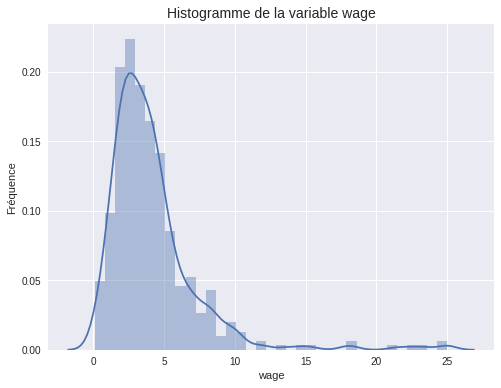

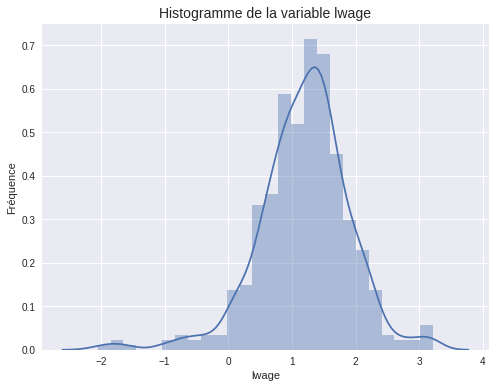

In [10]:
make_histo(df_mroz['wage'])
make_histo(df_mroz['lwage'])

#### Comparaison & Interprétation :
> Le salaire des femmes a une distribution log-normale : en effet, par une tranformation en log, on obtient une distribution d'une loi normale.

## Question 4 :

**Calculer les corrélations *motheduc* et *fatheduc*. Commentez. Il y a-t-il un problème de multicolinéarité si l'on utilise ces variables comme variables explicatives ?**

In [11]:
# Corrélations entre 'motheduc' et 'fatheduc'
pearson_corr = df_mroz[['motheduc', 'fatheduc']].corr(method='pearson').iloc[0, 1]
pearson_spear = df_mroz[['motheduc', 'fatheduc']].corr(method='spearman').iloc[0, 1]
print("Correlation de Pearson : %.6f" % pearson_corr)
print("Correlation de Spearman : %.6f" % pearson_spear)

Correlation de Pearson : 0.554063
Correlation de Spearman : 0.550733


#### Conclusion :
> Avec une telle valeur de corrélation, ces deux variables ne semblent pas corrélées. On ne peut justifier d'un problème de multicolinéarité.

## Question 5 :

**Faites un graphique en nuage de point entre *wage* et *educ*, *wage* et *exper*, *wage* et *fatheduc*.  
Commentez. S'agit-il d'un effet "toute chose étant égale par ailleurs" ?**

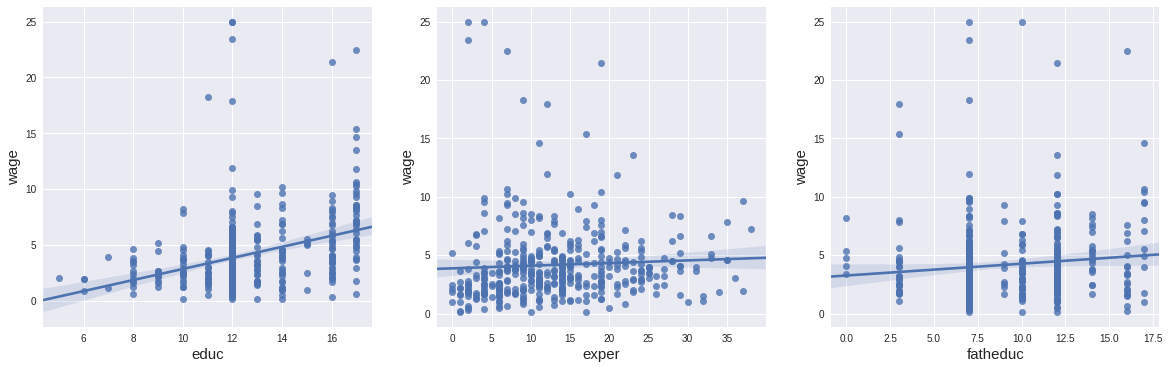

In [12]:
x_toPlot = [df_mroz['educ'], df_mroz['exper'], df_mroz['fatheduc']]
y = df_mroz['wage']

fig = plt.figure(figsize=(20, 20))
for i, x in enumerate(x_toPlot):
    plt.subplot(len(x_toPlot), len(x_toPlot), i+1)
    sns.regplot(x, y)
    plt.xlabel(x.name, fontsize=15)
    plt.ylabel('wage', fontsize=15)  
plt.show()

In [13]:
def compute_R2(X, y, add_intercept=True):
    
    # Add intercept if asked
    if add_intercept:
        X.insert(0, 'cste', 1)

    # Linear regression : compute beta coeficients
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    beta = beta.reshape(1, -1)
    
    # y_predicted
    y_hat = X.dot(beta.T)
    
    # compute R2 (determination coefficient)
    y = y.values
    y_hat = y_hat.values.reshape(-1)
    num = np.sum((y - y_hat)**2)
    denum = np.sum((y -  y.mean())**2)
    R2 = 1 - (num/denum)
    return R2


In [14]:
for X in [df_mroz[['educ']], df_mroz[['exper']], df_mroz[['fatheduc']]]:
    R2 = compute_R2(X, df_mroz.lwage, add_intercept=True)
    print("R2 (coefficient de détermination) pour {} = {:.6f}".format(X.columns[-1], R2))

R2 (coefficient de détermination) pour educ = 0.117883
R2 (coefficient de détermination) pour exper = 0.028673
R2 (coefficient de détermination) pour fatheduc = 0.006034


#### Interprétation : "tout chose étant égale par ailleurs"

> Il semble que chacune de ces trois variables ait un effet positif sur le salaire.

> On remarque cependant que le niveau d'éducation possède un plus fort effet positif sur le salaire comparativement à l'expérience et au niveau d'éducation du père.

> Pour chacune des 3 variables, le R2 est faible voire très faible. C'est-à-dire que ces variables, prises séparément, n'arrive pas à expliquer le salaire à elles seules.

> Donc on ne peut pas dire qu'il s'agit d'un effet "toute chose étant égale par ailleurs.


## Question 6 :

**Quelle est l'hypothèse fondamentale qui garantit des estimateurs non biaisés ? Expliquer le biais de variable omise.**

> ###### L'hypothèse fondamentale est l'hypothèse d'homoscédasticité :
  - Error variables have zero mean : $E(u) = 0$
  - Conditional expectation = unconditional expectation
  - X and u are uncorrelated : $E(u|x) = E(u) = 0$

## Question 7 :

**Faire la régression de *wage* en utilisant les variables explicatives : *constante*, *city*, *educ*, *exper*, *nwifeinc*, *kidslt6*, *kidsgt6*.  
Commentez l'histogramme des résidus.**

In [15]:
# First, we define a useful function to compute residuals and plot histogramm
def make_residuals_hist(X, y, add_intercept=True):
    # Compute residuals
    if add_intercept:
        X.insert(0, 'cste', 1)
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    u = y - X.dot(beta)
    # Plot histogramm of residuals
    plt.figure(figsize=(8,5))
    plt.hist(u, bins='auto')
    plt.xlabel("residus")
    plt.ylabel("Nombre d'observations")
    plt.title("Histogramme des résidus de la régression de {}".format(y.name), fontsize=15)
    plt.show()

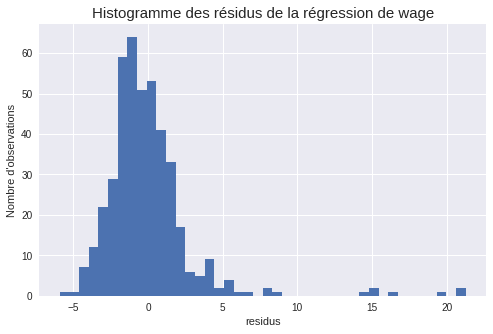

In [16]:
# wage
y = df_mroz.wage
X = df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]
make_residuals_hist(X, y, add_intercept=True)

#### Commentaire sur l'histogramme des résidus de *wage* :

> Les résidus semblent avoir une moyenne nulle mais ne sont pas parfaitement centrés en zéro (la queue de distribution sur la droite est trop importante).

## Question 8 :

**Faire la régression de lwage (log de wage) sur une constante, city, educ, exper, nwifeinc, kidslt6, kidsgt6.   
Comparer l’histogramme obtenu à celui de la question 7.**

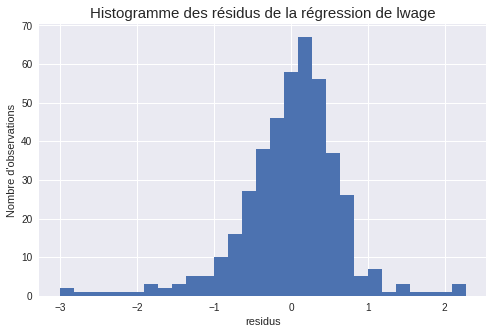

In [17]:
# log(wage)
y = df_mroz.lwage
X = df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]
make_residuals_hist(X, y, add_intercept=True)

#### Comparaison avec l'histogramme obtenu à la question précédente (qu. 7)
> Avec *lwage* (log de *wage*), les résidus sont moins dispersés, mais également plus symétrique par rapport au zéro.

> L'utilisation de *lwage* nous garantira un meilleur modèle.

---
# Définition de deux fonctions utiles

*Pour répondre à la question 9 ainsi qu'aux suivantes, nous avons créé deux fonctions utiles :  
 ```regression_residuals``` fait la régression et calcule les résidus ainsi que la somme de leurs carrés (SSR)  pour un modèle donné (avec possibilité de corriger le modèle via WLS),  
 ```compute_pValue``` calcule la p-valeur entre 2 modèles.*

In [18]:
def regression_residuals(X, y, add_intercept=True, wls_divisor=None, print_out=True):
    """
    Do regression on the model y = beta * X and return :
     degree of freedom, estimated coefficients, residuals, and sum of squared residuals.
    
    Parameters
    ----------
    X : array_like (pandas dataframe)
        The features matrix (without intercept), of shape (number of observations, number of features).
    
    y : 1D array
        The ouptput vector of the model, of shape (number of observations).
    
    add_intercept : bool, optional
        If True, add an intercept to the model as first feature (β0).
        Otherwise, it is not included. Defaults to True.
    
    wls_divisor : 1D array, optional
        Value used to divide y and all features in X by this vector.
        Used for Weighted Least Squares. Defaults to None (no WLS correction).
    
    print_out : bool, optional
        If True, print some outputs. Defaults to True.

    Returns
    -------
    model : a named tuple composed of :
        - dof : scalar
            The degree of freedom of the model.
        - beta : 1D array
            The estimated coefficients of the model.
        - residuals: 1D array
            The residuals of the models. Computed as : y - X*beta
        - ssr : scalar
            The sum of squared residuals
        
        ==> These different elements are accessible using : model.dof, model.beta, model.u, model.ssr
    """
    
    # Sanity check
    assert X.shape[0] == y.shape[0], "X and y don't have the same number of observations"
    
    # Add intercept if asked
    if add_intercept:
        X.insert(0, 'cste', 1) #index of insertion, label, value to insert
    
    # If a WLS vector is given, use it as divisor
    if wls_divisor is not None:
        y = y / wls_divisor
        X = np.divide(X, wls_divisor[:, np.newaxis])
    
    # Degrees of Freedom
    n, k = X.shape
    dof = n - k

    # Linear regression : compute beta coeficients
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    
    # Residuals : u = y − X ∗ β
    u = y - X.dot(beta)
    
    # Sum of Squared Residuals
    ssr = u.T.dot(u)
    
    # Print results if asked
    if print_out:
        df_beta = pd.DataFrame(data=beta, index=X.columns, columns=['beta = '])
        print(df_beta.T)   # .to_string(float_format=lambda x: '%.6f'%x)  # to change decimal's number to display
        print()
        print('dof = {}   (#obs:{} - #coeffs:{})'.format(dof, n, k))
        print('ssr = {:.6f}'.format(ssr))
    
    # Create a namedtuple to return results
    model = namedtuple("Model", ["dof", "beta", "u", "ssr"])
    
    return model(dof, beta, u, ssr)
    

In [19]:
def compute_pValue(Unrestricted_model, Restricted_model, print_res=True, return_res=False):
    
    # Get data from models
    dof_r = Restricted_model.dof
    ssr_r = Restricted_model.ssr
    dof_ur = Unrestricted_model.dof
    ssr_ur = Unrestricted_model.ssr
    
    # Compute p-value
    q = dof_r - dof_ur
    F = ((ssr_r - ssr_ur)/q)  /  (ssr_ur/dof_ur)
    p_value = scipy.stats.f.sf(F, q, dof_ur)
    
    if print_res:
        print("q =", q)
        print("F = {:.6f}".format(F))
        if p_value < 1e-6:
            print(" ==> p_value =", p_value)  # format scientifique
        else:
            print(" ==> p_value = {:.6f}".format(p_value)) # format avec decimales
    
    if return_res:
        return q, F, p_value
    

---
## Question 9 :

**Tester l'hypothèse de non significativité de exper avec un seuil de significativité de 1%, 5% et 10% (test alternatif des deux côtés).  
Commentez les p-values.**

> Unrestricted model  
$$ \log(wage) = \beta_0 + \beta_1 city + \beta_2 educ + \beta_3 exper + \beta_4 nwifeinc + \beta_5 kidslt6 + \beta_6 kidsge6 + u$$

> 

> Restricted model with $H_0 : \beta_3 = 0$  
$$ \log(wage) = \beta_0 + \beta_1 city + \beta_2 educ + \beta_4 nwifeinc + \beta_5 kidslt6 + \beta_6 kidsge6 + u$$

In [20]:
### UNRESTRICTED MODEL
y = df_mroz.lwage
X = df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]

Unrestricted_Model = regression_residuals(X, y, add_intercept=True)

             cste      city      educ     exper  nwifeinc   kidslt6   kidsge6
beta =  -0.398975  0.035268  0.102248  0.015488  0.004883 -0.045303 -0.011704

dof = 421   (#obs:428 - #coeffs:7)
ssr = 188.589980


#### Commentaire sur le modèle non contraint :
> On voit que la regression donne des valeurs positives pour $\beta_1$, $\beta_2$, $\beta_3$ et $\beta_4$. Ces variables ont un effet positif sur le salaire.  
> A l'inverse, $\beta_5$ et $\beta_6$ sont négatifs, ce qui signifie qu'avoir des enfants a un impact négatif sur le salaire.

In [21]:
### RESTRICTED MODEL
y = df_mroz.lwage
X = df_mroz[['city', 'educ', 'nwifeinc', 'kidslt6', 'kidsge6']]

Restricted_Model_q9 = regression_residuals(X, y, add_intercept=True)

             cste      city      educ  nwifeinc   kidslt6   kidsge6
beta =  -0.120822  0.041669  0.103025  0.002958 -0.095958 -0.046221

dof = 422   (#obs:428 - #coeffs:6)
ssr = 193.927103


In [22]:
compute_pValue(Unrestricted_Model, Restricted_Model_q9)

q = 1
F = 11.914359
 ==> p_value = 0.000613


#### Conclusion  :

> Ici, p-value < 0.01 < 0.05 < 0.1 donc on rejette $H_0$ ('exper' non significatif) à 1%, 5% et 10%.  
Il semble donc que l'expérience a un impact sur le salaire.

#### p-valeur (source: wikipedia)  
> Ce nombre est utilisé en statistiques inférentielles pour conclure sur le résultat d’un test statistique. La procédure généralement employée consiste à comparer la valeur-p à un seuil préalablement défini (traditionnellement 5 %). Si la valeur-p est inférieure à ce seuil, on rejette l'hypothèse nulle en faveur de l’hypothèse alternative, et le résultat du test est déclaré « statistiquement significatif ». Dans le cas contraire, si la valeur-p est supérieure au seuil, on ne rejette pas l’hypothèse nulle, et on ne peut rien conclure quant aux hypothèses formulées.


## Question 10 :

**Tester l’hypothèse que le coefficient associé à educ est égal à 10% avec un seuil de significativité de 5% (test à alternatif des deux côtés)**

> Unrestricted model
$$ \log(wage) = \beta_0 + \beta_1 city + \beta_2 educ + \beta_3 exper + \beta_4 nwifeinc + \beta_5 kidslt6 + \beta_6 kidsge6 + u$$

> 

> Restricted model with $H_0 : \beta_2 = 0.1$
$$ \log(wage) - 0.1*educ = \beta_0 + \beta_1 city + \beta_3 exper + \beta_4 nwifeinc + \beta_5 kidslt6 + \beta_6 kidsge6 + u$$

Remarque : On utilise le log de _wage_ pour avoir les effets des variables en pourcentage.

In [23]:
### UNRESTRICTED MODEL
    # already computed in question 9

In [24]:
### RESTRICTED MODEL
y = df_mroz.lwage - 0.1*df_mroz['educ']
X = df_mroz[['city', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]

Restricted_Model_q10 = regression_residuals(X, y, add_intercept=True)

             cste      city     exper  nwifeinc   kidslt6   kidsge6
beta =  -0.373464  0.036133  0.015498  0.005016 -0.043358 -0.012101

dof = 422   (#obs:428 - #coeffs:6)
ssr = 188.599902


In [25]:
compute_pValue(Unrestricted_Model, Restricted_Model_q10)

q = 1
F = 0.022149
 ==> p_value = 0.881762


#### Conclusion  :

> Ici, p-value > 0.05 donc on ne rejette pas $H_0$ ($\beta_2=0.1$) à 5%.

## Question 11 :

**Tester l’hypothèse jointe que le rendement de l’éducation est de 10% et que celui de l’expérience professionnelle est de 5%.**

> Unrestricted model
$$ \log(wage) = \beta_0 + \beta_1 city + \beta_2 educ + \beta_3 exper + \beta_4 nwifeinc + \beta_5 kidslt6 + \beta_6 kidsge6 + u$$

> 

> Restricted model with $H_0 : \beta_2 = 0.1 \ , \ \beta_3 = 0.05$
$$ \log(wage) - 0.1*educ - 0.05*exper = \beta_0 + \beta_1 city + \beta_4 nwifeinc + \beta_5 kidslt6 + \beta_6 kidsge6 + u$$

In [26]:
### UNRESTRICTED MODEL
    # already computed in question 9

In [27]:
### RESTRICTED MODEL
y = df_mroz.lwage - 0.1*df_mroz['educ'] - 0.05*df_mroz['exper']
X = df_mroz[['city', 'nwifeinc', 'kidslt6', 'kidsge6']]

Restricted_Model_q11 = regression_residuals(X, y, add_intercept=True)

             cste      city  nwifeinc   kidslt6   kidsge6
beta =  -1.012898  0.021205  0.009202  0.068012  0.065118

dof = 423   (#obs:428 - #coeffs:5)
ssr = 215.091802


In [28]:
compute_pValue(Unrestricted_Model, Restricted_Model_q11)

q = 2
F = 29.580753
 ==> p_value = 9.535559958512219e-13


#### Conclusion  :

> Ici, p-value < 0.05 donc on rejette $H_0$ ($\beta_2=0.1 \ , \ \beta_3=0.05$) à 5%.

## Question 12 :

**De combien augmente le salaire en pourcentage avec 10 années d’expérience ?**

> Unrestricted model  
$$ \log(wage) = \beta_0 + \beta_1 city + \beta_2 educ + \beta_3 exper + \beta_4 nwifeinc + \beta_5 kidslt6 + \beta_6 kidsge6 + u$$

In [29]:
### UNRESTRICTED MODEL
    # already computed in question 9

beta3 = Unrestricted_Model.beta[3]
print(' ==> β3 =', beta3)

 ==> β3 = 0.015487872095843352


> $\beta_3$ est estimé à environ $0.0155$. Ce qui veut dire qu'une année d'expérience rajoute au salaire un extra de : $0.0155*salaire$.  

>  

> Attention ! Pour calculer l'augmentation sur plusieurs années, il faut, chaque année, repartir du salaire augmenté de l'année précédente.  
La fonction ci-dessous permet de calculer l'augmentation cumulée facilement.

In [30]:
def augmentation_cumulee(salaire_ini, augmentation_annuelle, nb_annee_exp):
    salaire = salaire_ini
    for i in range(nb_annee_exp):
        salaire = salaire + salaire*augmentation_annuelle
    return salaire

In [31]:
salaire_ini = 1
nb_annee_exp = 10
salaire_final = augmentation_cumulee(salaire_ini, beta3, nb_annee_exp)

print("salaire de base :", salaire_ini)
print("salaire après {:d} ans d'expérience : {:.6f}".format(nb_annee_exp, salaire_final))

salaire de base : 1
salaire après 10 ans d'expérience : 1.166131


#### Conclusion :
> Après 10 ans d'expérience, la salaire aura augmenté de 16.61 %.

## Question 13 :

**Tester l’égalité des coefficients associés aux variables kidsgt6 et kidslt6. Interprétez.**

On veut tester ici $H_0 : \beta_5 = \beta_6$.

On va introduire une nouvelle variable $\theta_1 = \beta_5 - \beta_6$ et tester plutôt $H_0 : \theta_1 = 0$

> Unrestricted model (ré-écrit avec $\theta_1$) :
$$ \log(wage) = \beta_0 + \beta_1 city + \beta_2 educ + \beta_3 exper + \beta_4 nwifeinc + \theta1 kidslt6 + \beta_6 (kidslt6 + kidsge6) + u$$

>  

> Restricted model with $H_0 : \theta_1 = 0$
$$ \log(wage) = \beta_0 + \beta_1 city + \beta_2 educ + \beta_3 exper + \beta_4 nwifeinc + \beta_6 (kidslt6 + kidsge6) + u$$

In [32]:
### UNRESTRICTED MODEL
    # already computed in question 9

In [33]:
### RESTRICTED MODEL
y = df_mroz.lwage
X = df_mroz[['city', 'educ', 'exper', 'nwifeinc']]
X['kidslt6+kidsge6'] = df_mroz['kidslt6'] + df_mroz['kidsge6']

Restricted_Model_q13 = regression_residuals(X, y, add_intercept=True)

             cste      city     educ     exper  nwifeinc  kidslt6+kidsge6
beta =  -0.389241  0.034308  0.10127  0.015574  0.005008         -0.01503

dof = 422   (#obs:428 - #coeffs:6)
ssr = 188.651886


In [34]:
compute_pValue(Unrestricted_Model, Restricted_Model_q13)

q = 1
F = 0.138196
 ==> p_value = 0.710268


#### Conclusion  :

> Ici, p-value > 0.05 donc on ne rejette pas $H_0$ ($\mathbf{\beta_5 = \beta_6}$) à 5%.

## Question 14 :

**En utilisant le modèle de la question 7, faire le test d'hétéroscédasticité de forme linéaire en donnant la p-valeur. Corriger le problème par rapport à la variable la plus importante en utilisant la méthode des MCG. Comparer les écarts-types des coefficients estimés avec ceux obtenus à la question 7. Commenter.**

On veut tester :
> $H_0 : Var(u|x_1,x_2, ···,x_k) = \sigma^2$

Mais comme on suppose que les résidus sont de moyenne nulle, alors $Var(u|x) = \mathbf{E}(u^2|x)$.  
Et donc $H_0$ devient :
> $\mathbf{E}(u^2|x_1,x_2, ···,x_k) = \mathbf{E}(u^2) = \sigma^2$  
(c'est-à-dire que $u^2$ ne dépend pas des $x_1, ..., x_n$)

Unrestricted model :  
> $$ wage = \beta_0 + \beta_1 city + \beta_2 educ + \beta_3 exper + \beta_4 nwifeinc + \beta_5 kidslt6 + \beta_6 kidsge6 + u$$

Restricted model with $H_0 : \beta_1 = \beta_2 = \beta_3 = \beta_4 = \beta_5 = \beta_6 = 0$  (all the coefficients except intercept are zeros) :
> $$ wage = \beta_0 + u$$

In [35]:
### Calcul des Résidus sur le modèle non contraint
# Data
y = df_mroz.wage
X = df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]
# Regression
Unrestricted_Model_q14 = regression_residuals(X, y, add_intercept=True) #, print_out=False)
# Get residuals
u = Unrestricted_Model_q14.u

             cste      city      educ    exper  nwifeinc   kidslt6   kidsge6
beta =  -2.403454  0.369752  0.460048  0.02382  0.015245  0.036173 -0.061891

dof = 421   (#obs:428 - #coeffs:7)
ssr = 4083.813560


### Mais ici, on veut calculer les SSR par rapport à $u^2$ et non par rapport à $y$ :

In [36]:
u2 = u ** 2

In [37]:
### UNRESTRICTED MODEL ON SQUARED RESIDUALS
y = u2
X = df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]
Unrestricted_for_u2 = regression_residuals(X, y, add_intercept=True)

             cste      city      educ     exper  nwifeinc   kidslt6   kidsge6
beta =   1.485611  5.964392  0.807722 -0.534082   0.04349  4.957255 -0.401842

dof = 421   (#obs:428 - #coeffs:7)
ssr = 756183.496030


In [38]:
### RESTRICTED MODEL ON SQUARED RESIDUALS
y = u2
X = df_mroz[[]]
Restricted_for_u2 = regression_residuals(X, y, add_intercept=True)

            cste
beta =   9.54162

dof = 427   (#obs:428 - #coeffs:1)
ssr = 773347.081345


In [39]:
compute_pValue(Unrestricted_for_u2, Restricted_for_u2)

q = 6
F = 1.592618
 ==> p_value = 0.147661


#### Conclusion
> Ici, p-value > 0.05 donc on ne rejette pas $H_0$.

### Correction par rapport à la variable la plus importante

> La régression sur le modèle non contraint montre que c'est *educ* qui a le plus d'importance ($\beta_2=0.460048$)

> Nous allons donc tout diviser par $\sqrt{educ}$ :

On considère maintenant le modèle non contraint :

> $$ \frac{wage}{\sqrt{educ}} = \frac{\beta_0}{\sqrt{educ}}
+ \frac{\beta_1 city}{\sqrt{educ}}
+ \frac{\beta_2 educ}{\sqrt{educ}}
+ \frac{\beta_3 exper}{\sqrt{educ}}
+ \frac{\beta_4 nwifeinc}{\sqrt{educ}}
+ \frac{\beta_5 kidslt6}{\sqrt{educ}}
+ \frac{\beta_6 kidsge6}{\sqrt{educ}}
+ \frac{u}{\sqrt{educ}}$$


In [40]:
### Calcul des Résidus sur le modèle WLS (weighted least squares) non contraint

# Calcul of the divisor
sqrt_educ = np.sqrt(df_mroz.educ)
# Data
y = df_mroz.wage
X = df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]
# Regression with WLS parameter
Unrestricted_WLS = regression_residuals(X, y, add_intercept=True, wls_divisor=sqrt_educ)
# Get residuals
u_wls = Unrestricted_WLS.u

             cste      city      educ     exper  nwifeinc   kidslt6   kidsge6
beta =  -1.904292  0.341516  0.414086  0.024064  0.018241  0.089263 -0.037168

dof = 421   (#obs:428 - #coeffs:7)
ssr = 314.354490


In [41]:
# Calcul du carré des résidus
u2_wls = u_wls ** 2

In [42]:
### UNRESTRICTED WLS MODEL ON SQUARED RESIDUALS
y = u2_wls
X = df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]
Unrestricted_for_u2_wls = regression_residuals(X, y, add_intercept=True, wls_divisor=sqrt_educ)

             cste      city      educ     exper  nwifeinc   kidslt6   kidsge6
beta =   0.579272  0.384731  0.031384 -0.043997  0.003133  0.390862 -0.021401

dof = 421   (#obs:428 - #coeffs:7)
ssr = 399.673798


In [43]:
### RESTRICTED WLS MODEL ON SQUARED RESIDUALS
y = u2_wls
X = df_mroz[[]]
Restricted_for_u2_wls = regression_residuals(X, y, add_intercept=True, wls_divisor=sqrt_educ)

             cste
beta =   0.707625

dof = 427   (#obs:428 - #coeffs:1)
ssr = 407.326626


In [44]:
compute_pValue(Unrestricted_for_u2_wls, Restricted_for_u2_wls)

q = 6
F = 1.343529
 ==> p_value = 0.236439


In [45]:
std_dev_beta = Unrestricted_Model_q14.beta.std()
std_dev_beta_WLS = Unrestricted_WLS.beta.std()

print("Ecart Type des betas sur le modèle non contraint : %.6f" % std_dev_beta)
print("Ecart Type des betas sur le modèle WLS non contraint %.6f" % std_dev_beta_WLS)

Ecart Type des betas sur le modèle non contraint : 0.908932
Ecart Type des betas sur le modèle WLS non contraint 0.733475


#### Commentaire :
> En conrigeant le modèle avec la méthode des WLS, on a réduit l'écart-type des coefficients par rapport au modèle non corrigé (modèle de la question 7).

## Question 15 :

**Tester le changement de structure de la question 8 entre les femmes qui ont plus de 43 ans et les autres : test sur l'ensemble des coefficients. Refaire le test avec 3
groupes (mutuellement exclusifs) : les femmes de moins de 30 ans, entre 30 et 43 ans, plus de 43 ans. Donnez les p-valeurs**

$$ \log(wage) = \beta_0 + \beta_1 city + \beta_2 educ + \beta_3 exper + \beta_4 nwifeinc + \beta_5 kidslt6 + \beta_6 kidsge6 + u$$

### Séparation du dataset en 2 selon l'age des femmes

In [46]:
#### On sépare le dataset entre les femmes de 43 ans ou moins et les femmes de plus de 43 ans:
####   Et on fait une régression selon le modèle ci-dessus

# 1) Femmes de 43 ans ou moins
condition = df_mroz['age'] <= 43
df_mroz_under43 = df_mroz[condition]

y = df_mroz_under43.lwage
X = df_mroz_under43[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]

Unrestricted_WomenUnder43 = regression_residuals(X, y, add_intercept=True)

             cste      city      educ     exper  nwifeinc   kidslt6   kidsge6
beta =  -0.541177  0.084998  0.116725  0.020163  0.002559 -0.093295 -0.023323

dof = 235   (#obs:242 - #coeffs:7)
ssr = 110.644090


In [47]:
# 2) Femmes de plus de 43 ans
condition = df_mroz['age'] > 43
df_mroz_over43 = df_mroz[condition]

y = df_mroz_over43.lwage
X = df_mroz_over43[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]

Unrestricted_WomenOver43 = regression_residuals(X, y, add_intercept=True)

             cste     city      educ     exper  nwifeinc   kidslt6   kidsge6
beta =  -0.323201 -0.01884  0.085265  0.017837   0.00927 -0.009123 -0.024883

dof = 179   (#obs:186 - #coeffs:7)
ssr = 75.348171


In [48]:
### Test de Fisher après séparation du dataset

# Dataset total (calculé à la question 9)
SSR = Unrestricted_Model.ssr
dof = Unrestricted_Model.dof
# Femmes de 43 ans ou moins
SSR1 = Unrestricted_WomenUnder43.ssr
dof1 = Unrestricted_WomenUnder43.dof
# Femmes de plus de 43 ans
SSR2 = Unrestricted_WomenOver43.ssr
dof2 = Unrestricted_WomenOver43.dof

F = (SSR - (SSR1+SSR2)) / (SSR1+SSR2)  *  (dof1+dof2) / (dof - (dof1+dof2))
print("F = %.6f" % F)

# Compute p-value
q = dof - (dof1+dof2)
p_value = scipy.stats.f.sf(F, q, (dof1+dof2))
print("p value = %.6f" % p_value)

F = 0.826037
p value = 0.566036


#### Conclusion sur le dataset séparé en deux
> Ici, p-value > 0.05 donc on ne rejette pas $H_0$.

### Séparation du dataset en 3 selon l'age des femmes

In [49]:
# 1) Femmes de 30 ans ou moins
print("    -----   Femmes de 30 ans ou moins   ------")
condition = df_mroz['age'] <= 30
df_mroz_under30 = df_mroz[condition]
y = df_mroz_under30.lwage
X = df_mroz_under30[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]
Unrestricted_WomenUnder30 = regression_residuals(X, y, add_intercept=True)

# 2) Femmes de plus de 30, mais 43 au maximum
print("\n    -----   Femmes de plus de 30, mais 43 au maximum   ------")
condition = (df_mroz['age'] > 30) & (df_mroz['age'] <= 43)
df_mroz_30_43 = df_mroz[condition]
y = df_mroz_30_43.lwage
X = df_mroz_30_43[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]
Unrestricted_Women30_43 = regression_residuals(X, y, add_intercept=True)

# 3) Femmes de plus de 43 ans
print("\n    -----   Femmes de plus de 43 ans   ------")
condition = df_mroz['age'] > 43
df_mroz_over43 = df_mroz[condition]
y = df_mroz_over43.lwage
X = df_mroz_over43[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']]
Unrestricted_WomenOver43 = regression_residuals(X, y, add_intercept=True)

    -----   Femmes de 30 ans ou moins   ------
             cste      city      educ     exper  nwifeinc  kidslt6   kidsge6
beta =  -2.111331 -0.194635  0.221973  0.052105  0.016097 -0.20869  0.089801

dof = 12   (#obs:19 - #coeffs:7)
ssr = 3.387215

    -----   Femmes de plus de 30, mais 43 au maximum   ------
             cste     city      educ     exper  nwifeinc   kidslt6   kidsge6
beta =  -0.524523  0.08895  0.111627  0.021064   0.00284 -0.089247 -0.013521

dof = 216   (#obs:223 - #coeffs:7)
ssr = 106.093444

    -----   Femmes de plus de 43 ans   ------
             cste     city      educ     exper  nwifeinc   kidslt6   kidsge6
beta =  -0.323201 -0.01884  0.085265  0.017837   0.00927 -0.009123 -0.024883

dof = 179   (#obs:186 - #coeffs:7)
ssr = 75.348171


In [50]:
### Test de Fisher après séparation du dataset

# Dataset total (calculé à la question 9)
SSR = Unrestricted_Model.ssr
dof = Unrestricted_Model.dof
# Femmes de 30 ans ou moins
SSR1 = Unrestricted_WomenUnder30.ssr
dof1 = Unrestricted_WomenUnder30.dof
# Femmes de plus de 30, mais 43 au maximum
SSR2 = Unrestricted_Women30_43.ssr
dof2 = Unrestricted_Women30_43.dof
# Femmes de plus de 43 ans
SSR3 = Unrestricted_WomenOver43.ssr
dof3 = Unrestricted_WomenOver43.dof

F = (SSR - (SSR1+SSR2+SSR3)) / (SSR1+SSR2+SSR3)  *  (dof1+dof2+dof3) / (dof - (dof1+dof2+dof3))
print("F = %.6f" % F)

# Compute p-value
q = dof - (dof1+dof2+dof3)
p_value = scipy.stats.f.sf(F, q, (dof1+dof2+dof3))
print("p value = %.6f" % p_value)

F = 0.591585
p value = 0.872035


#### Conclusion sur le dataset séparé en trois
> Là encore, p-value > 0.05 donc on ne rejette pas $H_0$.

## Question 16 :

**A partir de la variable kidslt6, créer un ensemble de variables binaires pour le nombre d’enfants de moins de 6 ans. Refaire la question 8 avec ces variables et en utilisant comme référence les femmes qui ont des enfants de plus de 6 ans. Ces catégories sont-elles mutuellement exclusives ? Interprétez les paramètres associés aux variables binaires. Faire le test de non significativité de l’ensemble des variables binaires. Donnez les p-valeurs**

In [51]:
print("Nombre minimum d'enfants de -6 ans :", df_mroz["kidslt6"].min())
print("Nombre maximum d'enfants de -6 ans :", df_mroz["kidslt6"].max())

Nombre minimum d'enfants de -6 ans : 0
Nombre maximum d'enfants de -6 ans : 2


** Nous allons créer 3 variables binaires : Aucun d'enfant de -6 , Un enfant de -6 , Deux enfants de -6  
Ces variables sont mutuellement exclusives par construction. **

In [52]:
df_mroz["0_kidslt6"] = df_mroz["kidslt6"].map(lambda x : 1 if x==0 else 0)
df_mroz["1_kidslt6"] = df_mroz["kidslt6"].map(lambda x : 1 if x==1 else 0)
df_mroz["2_kidslt6"] = df_mroz["kidslt6"].map(lambda x : 1 if x==2 else 0)

** On enlève la variable 'Aucun enfant de -6 ans' **

In [53]:
### UNRESTRICTED MODEL
y = df_mroz.lwage
X = df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidsge6', '1_kidslt6', '2_kidslt6']]

binary_kidslt6_Model = regression_residuals(X, y, add_intercept=True)

             cste      city      educ     exper  nwifeinc   kidsge6  \
beta =  -0.397551  0.034609  0.102219  0.015437  0.004903 -0.011594   

         1_kidslt6  2_kidslt6  
beta =    -0.05403  -0.065028  

dof = 420   (#obs:428 - #coeffs:8)
ssr = 188.582182


#### Conclusion
> Avoir 1 enfant de -6 ans diminue le salaire de 5.4 % par rapport à une femme sans enfant de -6 ans (catégorie de référence).

> Avoir 2 enfants de -6 ans diminue le salaire de 6.5 % par rapport à une femme sans enfant de -6 ans (catégorie de référence).

---
# <center>Partie 2. Séries temporelles</center>
---

## Question 1 :

**Importer les données du fichier quarterly.xls (corriger le problème éventuel d’observations manquantes)**

In [54]:
#filepath2 = "/home/robin/Bureau/projet ses722/quarterly.xls"
filepath2 = "./data/quarterly.xls"

# Import
df = pd.read_excel(filepath2)

# Transform date in a correct datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

In [55]:
# Verification de possibles valeurs manquantes
number_null = df.isnull().sum().sum()
number_na = df.isna().sum().sum()

print("Nombre de valeurs manquantes = ", number_null + number_na)

Nombre de valeurs manquantes =  0


In [56]:
# Affichage des 5 premières lignes
df.head()

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
0,1960-01-01,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1,1960-04-01,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
2,1960-07-01,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
3,1960-10-01,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
4,1961-01-01,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073


## Question 2 :

**Calculer inf, le taux d’inflation à partir de la variable CPI. Faire un graphique dans le temps de inf. Commentez.**

In [57]:
# Calcul du taux d'inflation
CPI_t        = df['CPI'][1:].values
CPI_t_minus1 = df['CPI'][:-1].values

inflation = 100 * (CPI_t - CPI_t_minus1) / CPI_t_minus1                # OR : np.log(CPI_t/CPI_t_minus1)
inflation = np.insert(inflation, 0, values=0) # rajoute un 0 au début

df['inf'] = inflation  # ajoute l'inflation dans le dataframe

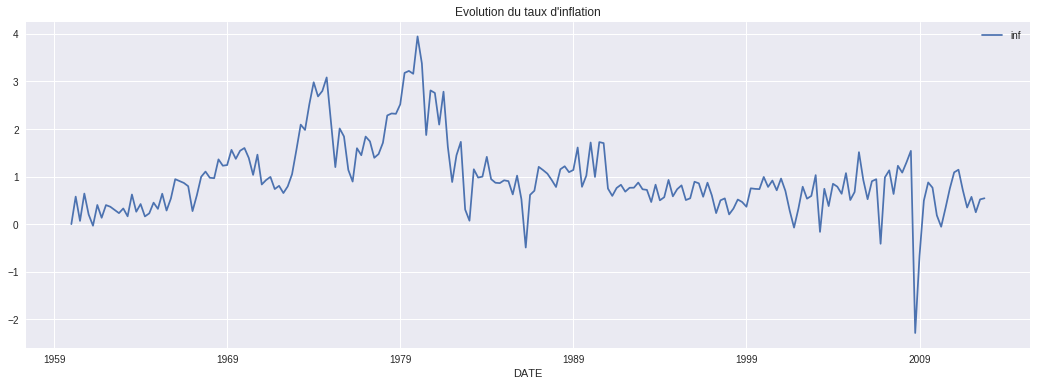

In [58]:
# Graphique
df.plot(x='DATE', y='inf', title="Evolution du taux d'inflation", figsize=(18,6))
plt.show()

#### Commentaire :
> Taux d'inflation croissant durant les années 1960.

> Puis pic d'inflation au début des années 1970, qui semble correspondre au Premier choc pétrolier (1973).

> Second pic à la fin de cette même décennie, qui montre le Second choc pétrolier (1979).

> Enfin, en 2008, on peut remarquer une très forte chute de l'inflation dûe certainement dûe à la crise économique dite des "sub-primes".

> ** Il ne semble pas y avoir de saisonnalité fortement marquée. La série ne semble pas stationnaire.   ????? VRAI ???**

## Question 3 :

**Interpréter l'autocorrélogramme et l'autocorrélogrammes partiels de inf. Quelle est la différence entre ces deux graphiques ?**

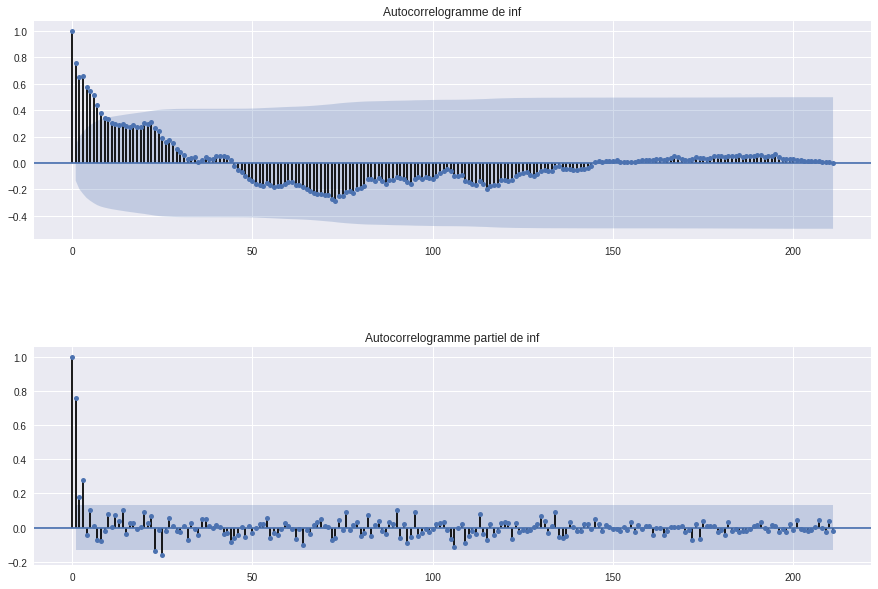

In [59]:
import pylab as pl
import statsmodels.api as sm
fig, axes = pl.subplots(2,1, figsize=(15,10))
fig.subplots_adjust(hspace=0.5)
fig=sm.graphics.tsa.plot_acf(df.inf.astype(np.float64),ax=axes[0])
axes[0].set_title("Autocorrelogramme de inf")
fig=sm.graphics.tsa.plot_pacf(df.inf, ax=axes[1])
axes[1].set_title("Autocorrelogramme partiel de inf")
plt.show()

Par lecture graphique :
* L'autocorrelation semble tendre vers 0
* L'autocorrelation partielle semble tomber a zero rapidement.
* il s'agit probablement d'un processus AR, selon l'autocorrélogramme partiel le nombre de retard significatif se situe en 1 et 5.

## Question 4 :

**Proposer une modélisation AR(p) de inf, en utilisant tous les outils vus au cours.**

* Objectif
    - Modélisation d'un processus stochastique qui génère la série temporelle observée.
    - Décompostion prévision erreur.
    
    
* Tendance = série non stationnaire:
* La distribution de xt et distribution xt-1


* Solution : stationnariser
* Modèle en différence
* Modèle en taux de croissance


* Sous l'hypothèse de stationnarité:
* Estimateurs MCO = meilleur non biaisé
    
KPSS test : Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.

In [60]:
import statsmodels.tsa.stattools as ts

unit_test = ts.adfuller(df.inf, regression="ct", autolag='AIC')

print("test stats : ", format(unit_test[0]))
print("p-value : ", format(unit_test[1]))
print("usedlag : ", format(unit_test[2]))
print("nombre observations : ", format(unit_test[3]))
print("valeurs critiques : ", format(unit_test[4]))
print("maximized information criterion : ", format(unit_test[5]))

test stats :  -3.252038584894522
p-value :  0.0745220986364763
usedlag :  2
nombre observations :  209
valeurs critiques :  {'1%': -4.0027517721652925, '5%': -3.4317085320958416, '10%': -3.139513599307244}
maximized information criterion :  275.4946609992428


La série est non stationnaire car p-value est supèrieure à 5% donc nous allons la stationnariser en calculant le différentiel.

In [61]:
inf_t        = df['inf'][1:].values
inf_t_minus1 = df['inf'][:-1].values

diff_inf = inf_t - inf_t_minus1
diff_inf = np.insert(diff_inf, 0, values=0) # rajoute un 0 au début

df['diff_inf'] = diff_inf  # ajoute le différentiel d'inflation dans le dataframe

In [62]:
unit_test = ts.adfuller(df['diff_inf'], regression="ct", autolag = 'AIC')
print("test stats : ", format(unit_test[0]))
print("p-value : ", format(unit_test[1]))
print("usedlag : ", format(unit_test[2]))
print("nombre observations : ", format(unit_test[3]))
print("valeurs critiques : ", format(unit_test[4]))
print("maximized information criterion : ", format(unit_test[5]))

test stats :  -10.044746288509446
p-value :  1.855427697120856e-15
usedlag :  3
nombre observations :  208
valeurs critiques :  {'1%': -4.002966509244673, '5%': -3.43181159172131, '10%': -3.139573978276485}
maximized information criterion :  284.5278606513089


In [63]:
ar_model = AR(list(df["diff_inf"]))
m = ar_model.fit(2, ic='aic', trend='ct')

In [64]:
print("Constante + Betas = ", m.params)
print()
print("Résidus = ", m.resid)
print()
print("MSE = ", (0.5* m.resid.mean()))

Constante + Betas =  [ 2.97568903e-02 -2.70995374e-04 -3.70305920e-01 -3.49629996e-01]

Résidus =  [-3.25958599e-01  5.58348392e-01 -4.35363969e-01 -2.25977972e-01
  1.66313782e-01 -2.17637749e-01  2.91573399e-01 -5.76338143e-02
 -1.45145350e-02 -1.31085144e-01  2.30751523e-02 -1.78635978e-01
  4.05256734e-01 -2.75906574e-01  1.62181700e-01 -3.52518209e-01
 -7.67488297e-04  1.32812439e-01 -4.91037631e-02  3.24632976e-01
 -3.05022173e-01  2.09238170e-01  3.52997450e-01  1.75540485e-01
  6.53013517e-02 -1.19911046e-01 -5.84878582e-01  9.28916899e-02
  3.06662321e-01  3.48139850e-01  2.48147705e-02 -4.03664312e-02
  3.26418315e-01 -9.67012095e-03  8.24841944e-02  2.57888692e-01
 -8.55315315e-02  1.93269933e-01  3.46863482e-02 -1.47129452e-01
 -4.31855412e-01  2.01844234e-01 -6.12156602e-01 -8.18151033e-03
 -1.36329245e-01 -2.15713985e-01 -2.07867404e-02 -2.32565095e-01
  9.10713908e-02  2.38727289e-01  6.36181654e-01  7.95973324e-01
  2.48886244e-01  6.72271662e-01  6.07436291e-01  4.7590

## Question 5 :

**Estimer le modèle de la courbe de Philips qui explique le taux de chômage (Unemp) en fonction du taux d’inflation et une constante.**

In [81]:
cho_t        = df['Unemp'][1:].values
cho_t_minus1 = df['Unemp'][:-1].values

diff_cho = cho_t - cho_t_minus1
diff_cho = np.insert(diff_cho, 0, values=0) # rajoute un 0 au début

df['diff_cho'] = diff_cho  # ajoute le différentiel d'inflation dans le dataframe

In [83]:
import statsmodels.api as sm

X = sm.add_constant(df.diff_inf)
y = df.diff_cho
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               diff_cho   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     5.156
Date:                Tue, 15 May 2018   Prob (F-statistic):             0.0242
Time:                        16:42:55   Log-Likelihood:                -67.467
No. Observations:                 212   AIC:                             138.9
Df Residuals:                     210   BIC:                             145.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0130      0.023      0.566      0.5

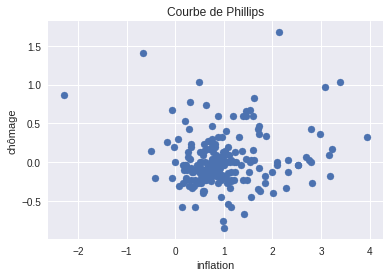

In [84]:
plt.scatter(df['inf'], df['diff_cho'])
plt.xlabel("inflation")
plt.ylabel("chômage")
plt.title("Courbe de Phillips")
plt.show()

## Question 6 :

**Tester l’autocorrélation des erreurs.**

In [85]:
u_t = results.resid[1:]
u_t_minus1 = results.resid[:-1]

y = u_t.reshape(-1, 1)
X = u_t_minus1.reshape(-1, 1)

rho = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
rho

array([[0.63439803]])

In [86]:
np.var(u_t)

0.1111719743421883

In [87]:
np.var(u_t_minus1)

0.11096138714764275

In [88]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     141.0
Date:                Tue, 15 May 2018   Prob (F-statistic):           3.25e-25
Time:                        16:43:15   Log-Likelihood:                -13.455
No. Observations:                 211   AIC:                             28.91
Df Residuals:                     210   BIC:                             32.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6344      0.053     11.874      0.0

Ici la variable rho est proche de 0 donc on en conclu que u_t et u_t_minus1 sont autocoréllés (leur variances respectives sont très proches l'une de l'autre)

La statistique de test est approximativement égale à 2 * (1-r) où r est l'autocorrélation de l'échantillon des résidus. Ainsi, pour r == 0, n'indiquant aucune corrélation sérielle, la statistique de test est égale à 2. Cette statistique sera toujours comprise entre 0 et 4. Plus la statistique est proche de 0, plus il y a de preuves de corrélation sérielle positive. Le plus proche de 4, plus la preuve de corrélation sérielle négative.

In [89]:
rho

array([[0.63439803]])

#### Conclusion :
> On voit que les erreurs ne s'expliquent pas en fonction des erreurs passées. Il n'est donc pas nécessaire de faire un modèle autorégréssif.

## Question 7 :

**Corriger l’autocorrélation des erreurs par la méthode vue en cours.**

In [90]:
X_inf = df['diff_inf'].values
X_inf = np.vstack((np.transpose(
    (np.ones(X_inf.shape[0]), X_inf))))

y_unemp = df['diff_cho'].values

# compute new y from 1 to n
y_part = np.array([y_unemp[i] - rho * y_unemp[i - 1]
                   for i in range(1, y_unemp.shape[0])])

# compute new X from 1 to n
X_part = np.zeros((X_inf.shape[0] - 1, X_inf.shape[1]))
for i in range(1, X_inf.shape[0]):
    X_part[i - 1] = X_inf[i] - rho * X_inf[i - 1]

# mcg correction
new_y = np.vstack((np.sqrt(
    1 - rho**2) * y_unemp[0].reshape(-1, 1), y_part.reshape(-1, 1)))
new_X_inf = np.vstack((np.transpose(
    (np.sqrt(1 - rho**2) * X_inf[0]).reshape(-1, 1)), X_part))

In [91]:
X = sm.add_constant(new_X_inf)
y = new_y
model = sm.OLS(y, X)
results = model.fit()

In [92]:
u_t = results.resid[1:]
u_t_minus1 = results.resid[:-1]

y = u_t.reshape(-1, 1)
X = u_t_minus1.reshape(-1, 1)

rho = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
rho

array([[0.06333157]])

#### Conclusion :
> Le rho est 10 fois plus proche de 0 cela veut dire que l'autocorrélation est corrigée.

## Question 8 :

**Tester la stabilité de la relation chômage-inflation sur deux sous-périodes de taille identique.**

Le test de Chow est un test statistique et économétrique afin de déterminer si les coefficients de deux séries linéaires sont égaux. Les coefficients sont établis par régression linéaire.

Il est surtout utilisé dans le cadre de séries temporelles pour savoir s'il y a une cassure significative par une certaine date qui séparerait les données en deux blocs ; il permet également d'évaluer l'impact des variables indépendantes sur les deux groupes ainsi construits. Ce test s'appuie sur la loi de Fisher.


Cc : Wikipedia

In [93]:
import chow_test
y1 = df.loc[df['DATE'] < '1986-01-01']['diff_cho']
x1 = df.loc[df['DATE'] < '1986-01-01']['diff_inf']
y2 = df.loc[df['DATE'] >= '1986-01-01']['diff_cho']
x2 = df.loc[df['DATE'] >= '1986-01-01']['diff_inf']

In [94]:
f_test = chow_test.f_value(y1, x1, y2, x2)
f_test

array([4.32224998])

La borne du Fisher $ F_{2;210}$ est d'environ 3,041 nettement inférieure à 4,322, on décide donc H1 le modèle est instalable.

## Question 9 :

**Estimer la courbe de Philips en ajoutant les délais d’ordre 1, 2, 3 et 4 de l’inflation. Faire le test de Granger de non causalité de l’inflation sur le chômage. Donnez la p-valeur**

In [95]:
df['lag1_inf']= df['diff_inf'].shift(1)
df['lag2_inf']= df['diff_inf'].shift(2)
df['lag3_inf']= df['diff_inf'].shift(3)
df['lag4_inf']= df['diff_inf'].shift(4)

In [96]:
df1 = df[['diff_cho', 'diff_inf', 'lag1_inf','lag2_inf','lag3_inf','lag4_inf']]
df1 = df1.dropna()

In [98]:
from sklearn.linear_model import LinearRegression

X = df1[['diff_inf', 'lag1_inf','lag2_inf','lag3_inf','lag4_inf']]
y = df1['diff_cho']
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

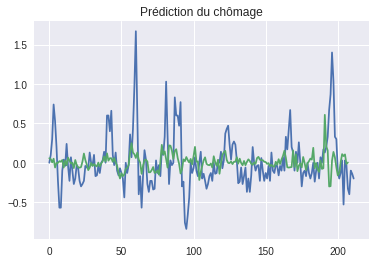

In [99]:
plt.plot(df['diff_cho'])
plt.plot(model.predict(X))
plt.title("Prédiction du chômage")
plt.show()

In [100]:
from statsmodels.tsa.stattools import grangercausalitytests
test = grangercausalitytests(df[['diff_cho', 'diff_inf']],
                      maxlag=4, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4906  , p=0.4844  , df_denom=208, df_num=1
ssr based chi2 test:   chi2=0.4977  , p=0.4805  , df=1
likelihood ratio test: chi2=0.4971  , p=0.4808  , df=1
parameter F test:         F=0.4906  , p=0.4844  , df_denom=208, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5109  , p=0.6007  , df_denom=205, df_num=2
ssr based chi2 test:   chi2=1.0468  , p=0.5925  , df=2
likelihood ratio test: chi2=1.0442  , p=0.5933  , df=2
parameter F test:         F=0.5109  , p=0.6007  , df_denom=205, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6549  , p=0.5807  , df_denom=202, df_num=3
ssr based chi2 test:   chi2=2.0329  , p=0.5656  , df=3
likelihood ratio test: chi2=2.0231  , p=0.5676  , df=3
parameter F test:         F=0.6549  , p=0.5807  , df_denom=202, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7654  , p=0.5489  

- Toutes les pvalues sont supérieures à 5% cela veut dire que l'inflation n'a pas d'influence sur le chômage.

---
# ANNEXE
---

In [101]:
def print_model(X, y, model_name=None):
    
    feat = []
    for i, feat_name in enumerate(X.columns):
        if feat_name == "cste":
            feat.append("β0")
        else:
            feat.append("β"+str(i)+"*"+feat_name)
    
    if model_name:
        print(" -- " + model_name + " -- ")
    print(y.name + " = " + " + ".join(feat))
    print()
    